<h1>NFL 1st and Future Playing Surface Analytics</h1>
<h2>Three Birds Systems Data Science Team<br>Howard E. Neely, III</h2>
<p>The objective of this project is to recommend rule changes to the NFL that are suggested and validated by the provided datasets.</p>
<p>We were provided three datasets to work with:  InjuryRecord, PlayList, and PlayerTrackData.  I make it a habit to always start by generating and examining the 
descriptive statistics of each raw dataset, to plan my work in cleaning and feature extraction and get an idea of what insights each dataset might yield.
I'll start with InjuryRecord.</p>
<p>But first, I'll initialize the environment with some imports I'll need:</p>
<h3>Imports</h3>

In [ ]:
import json
import math

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import xgboost           as xgb

from sklearn.metrics         import roc_curve
from sklearn.metrics         import auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing   import LabelEncoder

<h3>Data Preparation Functions</h3>

In [ ]:
NPSABASEDIR='../input/nfl-playing-surface-analytics/'
MYBASEDIR  ='../input/neelynflpsaworkfiles/'
WORKBASEDIR='/kaggle/working/'

def read_my_csv(datasetfile):
    return pd.read_csv(WORKBASEDIR+datasetfile)

def clean(df, col_name, old_string, new_string):
    """
    Replace all instances of an old string with a new string.

    Args:
        df: pandas DataFrame.
        col_name: String name of column to be cleaned.
        old_string: String to be found and removed.
        new_string: String to be inserted instead.
    """
    
    col = df[col_name]
    rej = col.str.contains(old_string)
    df[col_name] = np.where(rej, new_string, df[col_name])
    return

def make_dummy_variables(df, name, src_col_name):
    """
    Append a one-hot column to the DataFame with 1 in each row in which
    the corresponding row of the source column matches name, 0 otherwise.
    
    Args:
        df: pandas DataFrame.
        name: String value to match in source column.
        src_col_name: String name of the source column.
    """
    
    df[name] = [0 for x in range(df.index.size)]
    col   = df[src_col_name]
    match = col.str.contains(name)
    df[name] = np.where(match, 1, 0)
    return

def encode_string_values(df, col_name, num_values, mappings, save_mapping=False):
    """
    Append a new column to the DataFrame containing numeric mappings for string
    categorical values.

    It is wise to run fill_missing_with_text over the column prior to running
    this function.

    Args:
        df: pandas DataFrame.
        col_name: String name of column to be cleaned.
        num_values: int number of categorical values we expect.
        mappings: dictionary in which to insert a list of the string values.
          The index in the list is the new numeric value for that category.
        save_mapping: boolean used to control whether this is the first scan
          of the categoricals, in which case numeric values will be saved to
          mapping, or read from mapping for use with input data for inference.
    """

    new_col_name = col_name + '_code'
    if save_mapping:
        encoder = LabelEncoder()
        codes   = encoder.fit_transform(df[col_name])
        names   = encoder.inverse_transform(range(num_values))
        df[new_col_name] = codes
        mappings[col_name] = list(names)
        print('\nMapping of %s names:' % col_name)
        print(names)
    else:
        df[new_col_name] = df[col_name].apply(lambda x : mappings[col_name].index(x))
    return

def remap_categories(df, col_name, remap):
    """
    Append a new column to the DataFrame containing string categorical
    mappings defined in the remap DataFrame.

    Args:
        df: pandas DataFrame.
        col_name: String name of column to be remapped.
        remap: pandas DataFrame with the old values in column 0 and new
          values in column 1.
    """
    
    mp = {}
    for i in range(remap.index.size):
        mp[remap.iloc[i,0]] = remap.iloc[i,1]
        
    df['New_' + col_name] = df[col_name].map(mp)
    return
    
def fill_missing_with_text(df, col_name, text):
    """
    Replace all values in a column containing NaN with the provided text.

    Args:
        df: pandas DataFrame.
        col_name: String name of column to be cleaned.
        text: String value to use instead.
    """
    
    df[col_name] = df[col_name].fillna(value=text)
    return
    
def replace_numeric_with_median(df, col_name, value):
    """
    For all matching values in a column, replace with the median value of the column.

    Args:
        df: pandas DataFrame.
        col_name: String name of column to be cleaned.
        value: numeric value to replace.
    """
    
    chg = df[col_name] == value
    median= df[col_name].median()
    df[col_name] = np.where(chg, median, df[col_name])
    return

def drop_zero_columns(df):
    """
    Drop all columns that contain no non-zero values.

    Args:
        df: pandas DataFrame.

    Returns:
        DataFrame with no all-zero columns.
    """
    
    return df.loc[:, (df !=0).any(axis=0)]

def describe(dataset, inbasedir=NPSABASEDIR, outbasedir=WORKBASEDIR):
    """
    Make descriptive statistics for a dataset and write to a CSV file.

    Args:
        dataset: String for the dataset filename, without the extension.
    """
    
    filename = inbasedir+dataset+'.csv'
    print('\nReading dataset: ', filename)
    df = pd.read_csv(filename)
    stats = df.describe(include='all').transpose()
    stats.to_csv(outbasedir+dataset+'_stats.csv', index=False)
    print(stats)
    return



<h3>Machine Learning Functions</h3>

In [ ]:
def xgb_plot_feature_importances(model, model_name, group, dataset, injury, fold, auc):
    """
    Make a horizontal bar chart showing the top ten feature importances for the
    model with the given dataset and injury target.

    Args:
        model: A trained and fitted xgboost model.
        model_name: String of the model name.
        group: String for the two-letter PositionGroup the dataset covers. 
        dataset: String for the dataset filename, without the extension.
        injury: String for the BodyPart target on which the model is to be trained and fitted.
        fold: int value for the cross variance fold to be plotted.
        auc: float value of the area under the receiver operating characteristic (ROC)
             curve for this fold.
    """
    
    title = ('Top Ten Features for Prediction of %s %s injury\n' % (group, injury)) + \
    'Using the ' + model_name + ' model with the ' + dataset + ' dataset, fold ' + str(fold) + \
    ('\n(ROC AUC = %6.4f)' % auc)
    
    xgb.plot_importance(
        booster = model,
        ax      = None,
        height  = 0.2,
        xlim    = None,
        ylim    = None,
        title   = title,
        xlabel  = 'F score',
        ylabel  = 'Features',
        grid    = True,
        max_num_features = 10
        )
    plt.show()
    return

def xgb_crossvalidation(df, model_name, group, dataset, injury, target_drops,
                        params, nfolds=5, features=False):
    """
    Prepare data for cross validation using the XGBoost classifier.

    Args:
        df: pandas DataFrame still containing all targets.
        model_name: String of the model name.
        group: String for the two-letter PositionGroup the dataset covers. 
        dataset: String for the dataset filename, without the extension.
        injury: String for the BodyPart target on which the model was trained and fitted.
        target_drops: List of all target column names to be dropped before training.
        params: Dictionary of hyperparameters for the XGBoost classifier.
        nfolds: int value for the number of cross variance folds to process, default=5.
        features: boolean indicating whether feature importances are to be plotted
        instead of ROC curves.
    """
    
    y = df[injury]
    X = df.drop(columns=target_drops)
    title = model_name + ' using ' + dataset + ' for target ' + injury
    
    xgm = xgb.XGBClassifier(
        params        = params,
        random_state  = 45,
        n_jobs        =  8,
        )
    cross_val_with_roc(xgm, X, y, nfolds, model_name, group, dataset,
                       injury, title, features)
    return

def cross_val_with_roc(classifier, X, y, nfolds=5, model_name='', group='', dataset='',
                       injury='', title='Example', features=False):
    """
    Run n-fold cross-validation of classifier and plot multiple ROC curves on one chart.

    Args:
        classifier: model to be tested.
        X: DataFrame containing features.
        y: DataFrame containing the target.
        nfolds: int value for the number of cross variance folds to process, default=5.
        model_name: String of the model name.  Default is an empty string.
        group: String for the two-letter PositionGroup the dataset covers. 
        dataset: String for the dataset filename, without the extension.
        injury: String for the BodyPart target on which the model is to be trained and fitted.
        title: String title for use on the chart.
        features: boolean indicating whether feature importances are to be plotted
        instead of ROC curves.
    """
    
    plt.clf()
    cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=45)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        if features:
            xgb_plot_feature_importances(classifier, model_name, group, dataset,
                                         injury, i, roc_auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.6f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.6f $\pm$ %0.5f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return


In [ ]:
describe('InjuryRecord')

<p>We note that some PlayKey values are missing.  We can recover the missing PlayKey values by indexing into the PlayList dataset using GameID, then appending the final value of PlayerGamePlay to GameID to reconstruct the PlayKey.  We assume here that the play on which the player has an injury that will cost him some weeks of playing time will also be his final play of that game.  While we're at it, after reconstructing PlayKey, we can drop PlayerKey, GameID, and Surface from the new, cleaned dataset:  TBSNFLPLA00.</p>

In [ ]:
ir = pd.read_csv(NPSABASEDIR+'InjuryRecord.csv')
pl = pd.read_csv(NPSABASEDIR+'PlayList.csv')

# Repair missing PlayKey values.
pkn = ir['PlayKey'].isnull()
for i in range(ir.index.size):
    if pkn[i]:
        gameid = ir.loc[i, 'GameID']
        giddf  = pl[pl['GameID'] == gameid]
        pgp  = list(giddf['PlayerGamePlay'])
        pgpi = pgp[-1]
        pkm  = gameid + '-' + str(pgpi)
        ir.loc[i, 'PlayKey'] = pkm

#Drop unneeded columns.
ir.drop(columns=['PlayerKey', 'GameID', 'Surface'], inplace=True)
    
# Save cleaned file and descriptive statistics.
ir.to_csv(WORKBASEDIR+'TBSNFLPSA00.csv', index=False)
stats = ir.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA00_stats.csv')
print(stats)

<p>Now we see that we have all 105 injury records, and that two belong to an unfortunate player who got two injuries on the same play.  We see that Knee is the body part most frequently injured.  Let's examine that further.</p>

In [ ]:
injuries = [
    "Ankle",
    "Foot",
    "Heel",
    "Knee",
    "Toes"
    ]

num_injuries = len(injuries)
counts = [0 for x in range(num_injuries)]
for i in range(num_injuries):
    counts[i] = ir[ir['BodyPart'] == injuries[i]].shape[0]

explode = (0.1, 0, 0, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=explode, labels=injuries, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

<p>Here we see that Ankle and Knee injuries make up 85.7% of the total.  No other injury is even in double-digits of percentage points.  So, let's keep this insight in mind as we proceed to clean and transform the other datasets.  Next up is PlayList.</p>

In [ ]:
describe('PlayList')

<p>Tipped off by the "a free text description" comments in the data dictionary, we see that we need to do something about the values for StadiumType and Weather.  Looking at the 29 values for StadiumType, it seems that the essential issue is whether the stadium is indoor or has the potential of being indoor (e.g., sliding roof) venues, or are outdoors in the weather.  I decided to remap these 29 values to three:  Indoor, Outdoor, and NotReported.  This mapping is shown below:</p>

In [ ]:
stadia = pd.read_csv(MYBASEDIR+'StadiumType.csv')
print(stadia)

Weather is a 63 value variable that rambles all over the place.  I decided that the essential elements here were weather was Wet, Dry, or NotReported:

In [ ]:
weather = pd.read_csv(MYBASEDIR+'Weather.csv')
print(weather)

<p>The following additional issues were addressed in the clean-up of Play List:</p>
<ol>
    <li>Drop field “RosterPosition”.  This value doesn’t necessarily indicate the role of a player on a given play.  This information is already present in the “Position” field.</li>
    <li>Replace the “Temperature” values that show -999 with the median of the variable.</li>
    <li>For the “PlayType” field, remap the “0” values to NotReported, then map the eleven categorical val-ues to numeric values.</li>
    <li>For the “Position” field, map the 23 categorical values to numeric values.</li>
    <li>For the “PositionGroup” field, map the 9 categorical values to numeric values.</li>
</ol>
<p>The code that does this and remaps the StadiumType and Weather to form new derived dataset TBSNFLPSA01 is as follows:

In [ ]:
# Replace zero PlayType values with NotReported.
clean(pl, 'PlayType', '0', 'NotReported')

# Replace Temperature=-999 with mean.
replace_numeric_with_median(pl, 'Temperature', -999)

# Drop unneeded columns.
pl.drop(columns=['RosterPosition'], inplace=True)

# Fill missing categorical data with text.
fill_missing_with_text(pl, 'StadiumType', 'NotReported')
fill_missing_with_text(pl, 'Weather',     'NotReported')
fill_missing_with_text(pl, 'PlayType',    'NotReported')

# Map categorical variables.
mappings = {}
encode_string_values(pl, 'Position',      22, mappings, True)
encode_string_values(pl, 'PositionGroup',  9, mappings, True)
encode_string_values(pl, 'PlayType',      11, mappings, True)
encode_string_values(pl, 'FieldType',      2, mappings, True)

# Remap StadiumType before mapping to integers.
remap_categories(pl, 'StadiumType', stadia)
encode_string_values(pl, 'New_StadiumType', 3, mappings, True)
 
# Remap Weather before mapping to integers.
remap_categories(pl, 'Weather', weather)
encode_string_values(pl, 'New_Weather', 3, mappings, True)

# Save mappings to JSON file.
with open(WORKBASEDIR+'TBSNFLPSA01-variable-mappings.txt', 'w') as outfile:
    json.dump(mappings, outfile, indent=3)

# Save dataset and statistics to files.
pl.to_csv(WORKBASEDIR+'TBSNFLPSA01.csv', index=False)
stats = pl.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA01_stats.csv')
print(stats)


<p>Next, we'll join TBSNFLPSA00 and TBSNFLPSA01 on PlayKey to form TBSNFLPSA02:</p>

In [ ]:
# Join datasets on PlayKey.
j1 = pd.merge(pl, ir, how='left', on='PlayKey')

# Fill NaNs that appear due to the left join with reasonable values.
fill_missing_with_text(j1, 'BodyPart', 'None')
fill_missing_with_text(j1, 'DM_M1',    '0')
fill_missing_with_text(j1, 'DM_M7',    '0')
fill_missing_with_text(j1, 'DM_M28',   '0')
fill_missing_with_text(j1, 'DM_M42',   '0')

# Now that we also have "None" values, make dummy variables for BodyPart.
mappings = {}
encode_string_values(j1, 'BodyPart',    6, mappings, True)
for part in mappings['BodyPart']:
    make_dummy_variables(j1, part, 'BodyPart')

# Save mappings to file.
with open('TBSNFLPSA02-variable-mappings.txt', 'w') as outfile:
    json.dump(mappings, outfile, indent=3)

# Drop unnecessary columns.
drops = ['PlayerKey', 'GameID', 'FieldType', 'PlayType', 'StadiumType', 'New_StadiumType',
         'Weather', 'New_Weather'
         ]
j1.drop(columns=drops, inplace=True)

# Save dataset and statistics to files.
j1.to_csv(WORKBASEDIR+'TBSNFLPSA02.csv', index=False)
stats = j1.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA02_stats.csv')
print(stats)

<p>Now that we have a dataset that associates injury with position and position group, we can revisit the question of "who gets injured?"  Continuing our focus on Ankle and Knee injuries, this joined dataset now allows us to see the following for position groups (Ankle chart on top, Knee chart below):</p>

In [ ]:
injuries = [
    "Ankle",
    "Knee"
    ]

position_groups = [
      "DB",
      "DL",
      "LB",
      "OL",
      "QB",
      "RB",
      "SPEC",
      "TE",
      "WR"
   ]

npg    = len(position_groups)
counts = [0 for x in range(npg)]

for injury in injuries:
    inj  = j1[j1['BodyPart'] == injury]
    for i in range(npg):
        counts[i] = inj[inj['PositionGroup'] == position_groups[i]].shape[0]

    title = injury + ' Injuries by Position Group'
    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=position_groups, autopct='%1.1f%%', 
            startangle=90)
    ax1.axis('equal')
    plt.show()


<p>From these charts, we can confirm what was intuitively obvious:  the players who run the fastest and collide with the most other players get the most ankle and knee injuries.  Can we find something to do with running fast that is predictive of injury risk?  If so, the source data for that insight would be the PlayerTrackData. The descriptive statistics for the PlayerTrackData dataset are as follows:</p>

In [ ]:
describe('PlayerTrackData')

<p>Dataset PlayerTrackData is clean, but it is big, at 76.4M samples.  How can we effectively glean insight from this huge trove?  What are we looking for?</p>
<p>Sports medicine researchers agree that excessive rotational traction, which can be caused by cleats getting “caught” in the turf, can cause ankle and knee injuries, but there is no consensus on how much traction is too much [Villwock09].  But, we can estimate the forces on a player from the track data, right?</p>
<p>I used the 76 million timed position measurements to estimate linear acceleration magnitude and rotational acceleration magnitude using the difference equations shown below.  Since these accelerations are proportional to force and torque, respectively, these estimates correlate with forces and torques on the player.  Normalized histograms were made from these values to make much smaller and easy to use datasets that reflect the percentage of time each player is subjected to forces and torques at different levels, for every play.  I've provided the source code for this module, but used the previously computed files instead of running it.  The acceleration magnitude code took about 67 hours on an AWS ml.t2.2xlarge instance and the angular acceleration magnitude took about 24 hours on an ml.c5.4xlarge instance.</p>

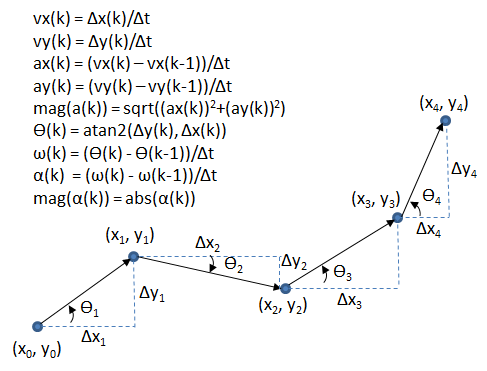

In [ ]:
def make_acceleration_histograms(df):
    """
    Library for generating the Histogram of Acceleration Magnitudes feature vector
    from the NFL Next Generation Statistics (NGS) PlayerTrackData dataset.

    This function computes sequences of velocities from the sequences of player (x,y)
    position data in the PlayerTrackData dataset, then computes sequences of acceleration
    from the sequences of velocities.  Acceleration magnitude is computed from the
    x and y components of acceleration.  Various sizes of histograms accumulate the
    number of times acceleration magnitudes are seen within the various bands.
    This serves to compress the acceleration magnitude sequence without losing
    information about peak values.  One row of histogram data is generated
    for each PlayerPlay, regardless of how long that play lasts.  Differences in
    play duration are mitigated when the histograms are normalized to percentages
    in the next feature extraction step.

    Args:
        df: a pandas DataFrame containing the PlayerTrackData dataset.
    """

    STATE_SIZE =  4
    IDT        = 10.0
    MAX_VALUE  = 30.0
    HISTO_LIST = [10, 20, 50, 100]

    # State Indices
    X_1 =  0
    Y_1 =  1
    XV_1=  2
    YV_1=  3

    class Filter:
        """
        Represents the displacement state of a player.

        Public methods:
        - update: Provide new (x,y) values to update state.
        - clear:  Reset state to zero.
        """
        
        def __init__(self):
            self.clear()
            return
        def update(self, x, y):
            """
            Uses (x,y) to update the player's angular state.

            Args:
                x: float value that is the player's position in yards
                  at a sample time along the long axis of the field.
                y: float value that is the player's position in yards
                  at a sample time along the short axis of the field.

            Returns:
                an estimate of the player's angular acceleration.
            """

            xv = IDT*(x  - self.state[X_1])
            yv = IDT*(y  - self.state[Y_1])
            xa = IDT*(xv - self.state[XV_1])
            ya = IDT*(yv - self.state[YV_1])

            self.state[X_1]  = x
            self.state[Y_1]  = y
            self.state[XV_1] = xv
            self.state[YV_1] = yv
            
            return (xv, yv, xa, ya)
        
        def clear(self):
            """
            Resets the state vector to zero.
            """
            
            self.state = np.array([0.0 for x in range(STATE_SIZE)])
            return 

    def make_col_names(nbins):
        """
        Makes a list of column name strings used to create the DataFrame.

        Args:
            nbins: int number of bins.

        Returns:
            list of column name strings.
        """
        
        return ['PlayKey'] + ['Bin'+str(x) for x in range(nbins)]

    def make_histos(df):
        """
        Generate angular acceleration magnitude histogram.

        Args:
            df: a pandas DataFrame containing the PlayerTrackData dataset.
        """
        
        size          = df.index.size
        histo_indices = range(len(HISTO_LIST))
        histos        = [{} for x in histo_indices]
        
        for i in histo_indices:
            nbins     = HISTO_LIST[i]
            histos[i] = {'nbins': nbins,
                         'histo': [],
                         'df'   : pd.DataFrame(columns=make_col_names(nbins)),
                         'bins' : np.linspace(start=0, stop=MAX_VALUE, num=nbins),
                         'index': 0
                         }
            
        # Initialize loop variables.        
        done      = False
        row_index = 0
        
        # Instantiate filter.
        kf = Filter()

        while not done:
            kf.clear()
            pk = df.loc[row_index, 'PlayKey']
            x  = df.loc[row_index, 'x']
            y  = df.loc[row_index, 'y']

            # Propogate out transients due to initial x,y.
            kf.update(x, y)
            kf.update(x, y) 
            kf.update(x, y)
            
            for i in histo_indices:
                nbins = histos[i]['nbins']
                histos[i]['histo'] = [0 for x in range(nbins)]
                
            while True: #for row_index in range(df.index.size):
                x = df.loc[row_index, 'x']
                y = df.loc[row_index, 'y']
                xv, yv, xa, ya = kf.update(x, y)
                ma = math.sqrt(xa*xa+ya*ya)

                for i in histo_indices:
                    nbins = histos[i]['nbins']
                    bins  = histos[i]['bins']
                    for bin_index in range(1, nbins):
                        if (ma >= bins[bin_index-1]) and (ma < bins[bin_index]):
                            histos[i]['histo'][bin_index-1] += 1
                            break
                    
                row_index += 1
                if row_index == size:
                    for i in histo_indices:
                        histo_index = histos[i]['index']
                        histo       = histos[i]['histo']
                        histos[i]['df'].loc[histo_index] = [pk] + histo
                    done = True
                    break
                elif pk != df.loc[row_index, 'PlayKey']:
                    for i in histo_indices:
                        histo_index = histos[i]['index']
                        histo       = histos[i]['histo']
                        histos[i]['df'].loc[histo_index] = [pk] + histo
                        histos[i]['index'] += 1
                    break

        #Writing datasets.
        for i in histo_indices:
            df = histos[i]['df']
            dataset = 'histo-' + str(HISTO_LIST[i])
            df.to_csv(dataset + '.csv', index=False)
            stats = df.describe(include='all').transpose()
            stats.to_csv(dataset+'_stats.csv', index=False)
        return
       
    make_histos(df)
    return

def make_angular_acceleration_histograms(df):
    """
    Generate the Histogram of Angular Acceleration Magnitudes feature vectors
    from the NFL Next Generation Statistics (NGS) PlayerTrackData dataset.

    This function computes sequences of angles from the sequences of player (x,y) position
    in the PlayerTrackData dataset, then computes sequences of angular velocity from
    the sequences of angles, and angular accelerations from the sequences of velocities.
    Angular acceleration magnitude is computed by taking the absolute value of the
    angular acceleration.  Various sizes of histograms accumulate the number of times
    angular acceleration magnitudes are seen within the various bands.  This serves to
    compress the angular acceleration magnitude sequence without losing information about
    peak values.  One row of histogram is generated for each PlayerPlay.  Differences in
    play duration are mitigated when the histograms are normalized to percentages in the next
    feature extraction step.

    Args:
        df: a pandas DataFrame containing the PlayerTrackData dataset.
    """

    STATE_SIZE  =  9
    IDT         = 10.0
    MAX_VALUE   = 30.0
    HISTO_LIST  = [10, 20]
    HISTO_DEPTH = 266960

    # State Indices
    X_1     = 0
    Y_1     = 1
    XV_1    = 2
    YV_1    = 3

    THETA   = 4
    OMEGA   = 5
    ANGAC   = 6

    THETA_1 = 7
    OMEGA_1 = 8

    class Filter:
        """
        Represents the angular state of a player.

        Public methods:
        - update: Provide new (x,y) values to update state.
        - clear:  Reset state to zero.
        """
        
        def __init__(self):
            self.clear()
            return
        def update(self, x, y):
            """
            Uses (x,y) to update the player's angular state.

            Args:
                x: float value that is the player's position in yards
                  at a sample time along the long axis of the field.
                y: float value that is the player's position in yards
                  at a sample time along the short axis of the field.

            Returns:
                an estimate of the player's angular acceleration.
            """

            th = math.atan2((y - self.state[Y_1]), (x - self.state[X_1]))
            om = IDT*(th - self.state[THETA_1])
            aa = IDT*(om - self.state[OMEGA_1])

            self.state[X_1]  = x
            self.state[Y_1]  = y
            
            self.state[THETA_1] = th
            self.state[OMEGA_1] = om
            return aa
        
        def clear(self):
            """
            Resets the state vector to zero.
            """
            
            self.state = np.array([0.0 for x in range(STATE_SIZE)])
            return 

    def make_col_names(nbins):
        """
        Makes a list of column name strings used to create the DataFrame.

        Args:
            nbins: int number of bins.

        Returns:
            list of column name strings.
        """
        
        return ['PlayKey'] + ['Bin'+str(x) for x in range(nbins)]

    def make_histos(df):
        """
        Generate angular acceleration magnitude histogram.

        Args:
            df: a pandas DataFrame containing the PlayerTrackData dataset.
        """
        
        size          = df.index.size
        histo_indices = range(len(HISTO_LIST))
        histos        = [{} for x in histo_indices]
        
        for i in histo_indices:
            nbins     = HISTO_LIST[i]
            columns   = make_col_names(nbins)
            histos[i] = {'nbins': nbins,
                         'histo': [],
                         'df'   : pd.DataFrame(columns=columns),
                         'bins' : np.linspace(start=0, stop=MAX_VALUE, num=nbins),
                         'index': 0
                         }
            for column in columns:
                histos[i]['df'][column] = [0 for x in range(HISTO_DEPTH)]

        # Initialize loop variables.        
        done      = False
        row_index = 0

        # Instantiate filter.
        kf = Filter()

        while not done:
            kf.clear()
            pk = df.loc[row_index, 'PlayKey']
            x  = df.loc[row_index, 'x']
            y  = df.loc[row_index, 'y']
            
            # Propogate out transients due to initial x,y.
            kf.update(x, y)
            kf.update(x, y)
            kf.update(x, y)
            
            for i in histo_indices:
                nbins = histos[i]['nbins']
                histos[i]['histo'] = [0 for x in range(nbins)]
                
            while True: #for row_index in range(df.index.size):
                x = df.loc[row_index, 'x']
                y = df.loc[row_index, 'y']
                aa = kf.update(x, y)

                for i in histo_indices:
                    nbins = histos[i]['nbins']
                    bins  = histos[i]['bins']
                    for bin_index in range(1, nbins):
                        if (aa >= bins[bin_index-1]) and (aa < bins[bin_index]):
                            histos[i]['histo'][bin_index-1] += 1
                            break
                    
                row_index += 1
                if row_index == size:
                    for i in histo_indices:
                        histo_index = histos[i]['index']
                        histo       = histos[i]['histo']
                        histos[i]['df'].loc[histo_index] = [pk] + histo
                    done = True
                    break
                elif pk != df.loc[row_index, 'PlayKey']:
                    for i in histo_indices:
                        histo_index = histos[i]['index']
                        histo       = histos[i]['histo']
                        histos[i]['df'].loc[histo_index] = [pk] + histo
                        histos[i]['index'] += 1
                    break
                
        #Writing datasets
        for i in histo_indices:
            df = histos[i]['df']
            dataset = 'angular-histo-' + str(HISTO_LIST[i])
            df.to_csv(dataset + '.csv', index=False)
            stats = df.describe(include='all').transpose()
            stats.to_csv(dataset+'_stats.csv')
        return

    make_histos(df)
    return

In [ ]:
describe('histo-20_normalized', inbasedir=MYBASEDIR)

<p>TBSNFLPSA03 is formed by joining TBSNFLPSA02 with the normalized 20-bin linear acceleration magnitude histogram, as follows:

In [ ]:
h20 = pd.read_csv(MYBASEDIR+'histo-20_normalized.csv')

# Join datasets on PlayKey.
j2 = pd.merge(j1, h20, how='inner', on='PlayKey')

# Drop rows with with bad PlayerDay values.
j2.drop(j2.loc[j2['PlayerDay'] < 0].index, inplace=True)

# Save dataset and statistics to files.
j2.to_csv(WORKBASEDIR+'TBSNFLPSA03.csv', index=False)
stats = j2.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA03_stats.csv')
print(stats)


<p>Now that we have a complete dataset, we can start doing some experimenting.  I like to start with decision trees, because they aren't finicky about normalization, and they provide some insight into which features are important.  XGBoost is an agressive gradient boosted tree that I'll start with for my experiment.</p>
<p>First, I'll try the whole dataset for an Ankle target.  I'll do some hyperparameter optimization first.</p>

In [ ]:
from sklearn.model_selection  import RandomizedSearchCV

def optimize(model, df, model_name, dataset, injury, initial=False):
    """
    Optimize XGBoost hyperparameters via randomized search over
    cross validation results.

    Args:
        model: A classifier model ready to be trained.
        df: pandas DataFrame still containing all targets.
        model_name: String of the model name.
        dataset: String for the dataset filename, without the extension.
        injury: String for the BodyPart target on which the model is to
          be trained and fitted.
        initial: boolean indicating if an initial set of parameters is to
          be used for all models, or is a model-specific set to be used.

    Returns:
        Dictionary of the best param set.    
    """
    y = df[injury]
    X = df.drop(columns=target_drops)
    if initial:
        clf  = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid_initial,
            scoring='roc_auc',
            random_state=42,
            verbose=1,
            cv=5,
            n_iter=50
            )
    else:
        clf  = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid_model_specific[model_name],
            scoring='roc_auc',
            random_state=42,
            verbose=1,
            cv=5,
            n_iter=50
            )
    search = clf.fit(X, y)
    print('\nModel %s and dataset %s, for %s injury:\n' % (model_name, dataset, injury))
    print(search.best_params_)
    print('Best score= %6.4f' % clf.best_score_)
    return search.best_params_


In [ ]:
target_drops = [
    "Ankle",
    "Foot",
    "Heel",
    "Knee",
    "Toes",
    "None"
    ]

feature_drops = [
    "PlayKey",
    "BodyPart",
    "BodyPart_code",
    "Position",
    "PositionGroup",
    "PositionGroup_code",
    "DM_M1",
    "DM_M7",
    "DM_M28",
    "DM_M42"
    ]

minimal_params = {
    'eval_metric': "auc"
    }

param_grid_initial = {
    'max_depth':         [x for x in range(6,    100)],
    'learning_rate':     np.linspace(0.06, 0.09,  50),
    'subsample':         np.linspace(0.4,  1.0,   50),
    'colsample_bytree':  np.linspace(0.3,  1.0,   50),
    'colsample_bylevel': np.linspace(0.3,  1.0,   50)
    }

gbm = xgb.XGBClassifier(
    params        = minimal_params,
    n_jobs        = 16
    )

def run_opt(runs, param_file):
    """
    Optimize sets of hyperparameters for specified models and write parameters
    to specified JSON file.

    Args:
        runs: List of dictionaries containing the parameters to be used
          to train, fit, and evaluate a group of models.
        param_file: String filename for the destination JSON file.
    """
    params     = {}
    param_sets = []
    for run in runs:
        dataset = run['dataset']
        injury  = run['injury']
        model   = run['model']
        group   = run['group']
        
        print('\nReading dataset %s.' % dataset)
        data=pd.read_csv(WORKBASEDIR+dataset+'.csv')
        data.drop(columns=feature_drops, inplace=True)
        print('Optimizing model %s for the %s position group with %s injury.' %
              (model, group, injury))
        try:
            params = optimize(gbm, data, model, dataset, injury, initial=True)
        except:
            print('An error occurred, saving what we have.')
            with open(param_file, 'w') as outfile:
                json.dump(param_sets, outfile, indent=3)
            exit(1)
        param_set = {}
        param_set['model']   = model
        param_set['dataset'] = dataset
        param_set['target']  = injury
        param_set['group']   = group
        param_set['params']  = params
        param_sets.append(param_set)

    with open(WORKBASEDIR+param_file, 'w') as outfile:
        json.dump(param_sets, outfile, indent=3)
    return

In [ ]:
from scipy                   import interp

def run_cv(param_file):
    """
    Run cross-validation on models, datasets, and parameters specified in
    JSON file.

    Args:
        param_file: String filename for the source JSON file.
    """
    with open(WORKBASEDIR+param_file, 'r') as json_file:
        runs = json.load(json_file)

    for run in runs:
        model   = run['model']
        dataset = run['dataset']
        target  = run['target']
        params  = run['params']
        group   = run['group']
        
        print('Reading dataset %s.' % dataset)
        data=pd.read_csv(WORKBASEDIR+dataset+'.csv')
        data.drop(columns=feature_drops, inplace=True)
        xgb_crossvalidation(data, model, group, dataset, target, target_drops, params)
    return

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM00',
     'dataset': 'TBSNFLPSA03',
     'group':   'All',
     'injury':  'Ankle'
     }
    ]
run_opt(runs, 'PSA00.json')

In [ ]:
run_cv('PSA00.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM01',
     'dataset': 'TBSNFLPSA03',
     'group':   'All',
     'injury':  'Knee'
     }
    ]
run_opt(runs, 'PSA01.json')  

In [ ]:
run_cv('PSA01.json')   

<p>Both ROC charts are disappointing, providing about the predictive power of pure chance.  Clearly, this will not be an approach that will provide insightful features.  Since we saw that the DB, WR, and LB position groups had high numbers of injuries, let's give those groups a try.</p>

In [ ]:
lb = j2[j2['PositionGroup'] == 'LB']
lb.to_csv(WORKBASEDIR+'TBSNFLPSA04.csv', index=False)
stats = lb.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA04_stats.csv')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM02',
     'dataset': 'TBSNFLPSA04',
     'group':   'LB',
     'injury':  'Ankle'
     }
    ]

run_opt(runs, 'PSA02.json')
run_cv('PSA02.json')  

In [ ]:
wr = j2[j2['PositionGroup'] == 'WR']
wr.to_csv(WORKBASEDIR+'TBSNFLPSA07.csv', index=False)
stats = wr.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA07_stats.csv', index=False)

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM09',
     'dataset': 'TBSNFLPSA07',
     'group':   'WR',
     'injury':  'Knee'
     }
    ]

run_opt(runs, 'PSA09.json')
run_cv('PSA09.json')   

In [ ]:
db = j2[j2['PositionGroup'] == 'DB']
db.to_csv(WORKBASEDIR+'TBSNFLPSA05.csv', index=False)
stats = db.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA05_stats.csv', index=False)

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM04',
     'dataset': 'TBSNFLPSA05',
     'group':   'DB',
     'injury':  'Ankle'
     }
    ]

run_opt(runs, 'PSA04.json')
run_cv('PSA04.json')  

<p>These are not predictive models.  This result greatly motivates the addition of the rotational acceleration magnitude histogram data.  First, we're going to normalize the histogram to percentages.</p>

In [ ]:
HISTO_LIST = [10, 20]

def normalize_histogram(df):
    """
    Normalize the histogram values to percentage across the row.

    Args:
        df: histogram DataFrame containing histogram columns and
        a PlayKey column.

    Returns:
        Normalized histograms (with PlayKey restored).    
    """
    data  = drop_zero_columns(df.drop(columns=['PlayKey']))
    norm  = data.div(data.sum(axis=1), axis=0)
    norm['PlayKey'] = df['PlayKey']
    return norm

for nbins in HISTO_LIST:
    dataset = 'angular-histo-' + str(nbins)
    df = pd.read_csv(MYBASEDIR+dataset+'.csv')
    norm = normalize_histogram(df)
    normed_dataset = dataset+'_normalized'
    norm.to_csv(WORKBASEDIR+normed_dataset+'.csv', index=False)

    stats = norm.describe(include='all').transpose()
    stats_of_normed = normed_dataset+'_stats'
    stats.to_csv(WORKBASEDIR+stats_of_normed+'.csv', index=False)

In [ ]:
describe('angular-histo-20_normalized', inbasedir=WORKBASEDIR)

<p>Let's get a better look at this histogram...with a set of histograms, one for each remaining bin (bin19 was empty, so was dropped).  It's a metahistogram!

In [ ]:
def make_metahistogram(df, ncols=4, nbins=50, prefix=''):
    """
    Make rectangular array of histograms of the bin contents of a histogram.

    Args:
        df: pandas DataFrame containing histogram only.  Any other columns
          need to be dropped before the call.
        ncols: int number of columns, so you can format to your page.
        nbins: int number of bins to use for the bin histograms.
        prefix: String with prefix to be used in the bin titles.
    """
    
    binsize = df.columns.size
    nrows   = math.ceil(binsize/ncols)
                
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, tight_layout=False)
    
    bin_index = 0
    row_index = 0
    col_index = 0
    done      = False
    
    for row in ax:
        for col in row:
            if done:
                fig.delaxes(ax[row_index][col_index])
            else:
                x = list(df.iloc[:, bin_index])
                col.hist(x, bins=nbins)
                col.set_title(prefix+'Bin' + str(bin_index))
                
            bin_index += 1
            col_index += 1
            if bin_index == binsize:
                done = True
        row_index += 1
        col_index  = 0
    plt.show()
    return

In [ ]:
make_metahistogram(pd.read_csv(WORKBASEDIR+'angular-histo-20_normalized.csv').drop(columns=['PlayKey']))

<p>Just look at the distributions in these histogram bins!  Any data scientist in the world would love to have a feature extraction algorithm that produced such nicely distributed data from real-world time-series position data, right?</p>
<p>Now, we join the 20-bin angular acceleration histogram to the full dataset, TBSNFLPSA03.</p>

In [ ]:
jd = pd.read_csv(WORKBASEDIR+'TBSNFLPSA03.csv')
hs = pd.read_csv(MYBASEDIR+'angular-histo-20_normalized.csv')

# Join datasets on PlayKey.
j1 = pd.merge(jd, hs, how='inner', on='PlayKey')

# Drop rows with with bad PlayerDay values.
j1.drop(j1.loc[j1['PlayerDay'] < 0].index, inplace=True)

# Save dataset and statistics to files.
j1.to_csv(WORKBASEDIR+'TBSNFLPSA09.csv', index=False)
stats = j1.describe(include='all').transpose()
stats.to_csv(WORKBASEDIR+'TBSNFLPSA09_stats.csv', index=False)
print(stats)

<p>Now, generate the separate datasets for each position group.</p>

In [ ]:
PGs = ['LB', 'DB', 'RB', 'WR']

df = pd.read_csv(WORKBASEDIR+'TBSNFLPSA09.csv')

for i in range(len(PGs)):
    dataset = "TBSNFLPSA%02d" % (i+10)
    print('%s.py:  TBSNFLPSA09 for players in the %s PositionGroup only.' % (dataset, PGs[i]))
    print('Extract rows for players in the %s PositionGroup.' % PGs[i])
    pg = df[df['PositionGroup'] == PGs[i]]

    print('Save dataset and statistics to files.')
    pg.to_csv(WORKBASEDIR+dataset+'.csv', index=False)
    stats = pg.describe(include='all').transpose()
    stats.to_csv(WORKBASEDIR+dataset+'_stats.csv', index=False)
    describe(dataset, inbasedir=WORKBASEDIR)
    print('\n')

<p>Now, we'll do a hyperparameter optimization for each new model, and take a look at the five-fold crossvalidation to see if we're doing any better.</p>

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM10',
     'dataset': 'TBSNFLPSA09',
     'group':   'All',
     'injury':  'Ankle'
     }
    ]

run_opt(runs, 'PSA10.json')
run_cv('PSA10.json')  

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM11',
     'dataset': 'TBSNFLPSA09',
     'group':   'All',
     'injury':  'Knee'
     }
    ]

run_opt(runs, 'PSA11.json')
run_cv('PSA11.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM12',
     'dataset': 'TBSNFLPSA10',
     'group':   'LB',
     'injury':  'Ankle'
     }
    ]

run_opt(runs, 'PSA12.json')
run_cv('PSA12.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM13',
     'dataset': 'TBSNFLPSA10',
     'group':   'LB',
     'injury':  'Knee'
     }
    ]

run_opt(runs, 'PSA13.json')
run_cv('PSA13.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM14',
     'dataset': 'TBSNFLPSA11',
     'group':   'DB',
     'injury':  'Ankle'
     }
    ]

run_opt(runs, 'PSA14.json')
run_cv('PSA14.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM15',
     'dataset': 'TBSNFLPSA11',
     'group':   'DB',
     'injury':  'Knee'
     }
    ]

run_opt(runs, 'PSA15.json')
run_cv('PSA15.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM17',
     'dataset': 'TBSNFLPSA12',
     'group':   'RB',
     'injury':  'Knee'
     }
    ]

run_opt(runs, 'PSA17.json')
run_cv('PSA17.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM18',
     'dataset': 'TBSNFLPSA13',
     'group':   'WR',
     'injury':  'Ankle'
     }
    ]

run_opt(runs, 'PSA18.json')
run_cv('PSA18.json')

In [ ]:
runs = [
    {'model':   'TBSNFLPSAPM19',
     'dataset': 'TBSNFLPSA13',
     'group':   'WR',
     'injury':  'Knee'
     }
    ]

run_opt(runs, 'PSA19.json')
run_cv('PSA19.json')

In [ ]:
import matplotlib.ticker as ticker

def make_injury_vs_angular_accel_histogram(dataset, group):
    """
    Make a bar chart showing the median of angular acceleration magnitude
    percentages for Ankle, Knee, and None body parts for each bin of the histogram
    (fields RotBin0 to RotBin18).

    Args:
        dataset: String for the dataset filename, without the extension.
        group: String for the two-letter PositionGroup the dataset covers. 
    """
    
    plt.clf()
    print('Read %s data.' % dataset)
    df   = pd.read_csv(dataset+'.csv')
    code = pd.DataFrame(df['BodyPart_code'].apply(lambda x : int(x)))
    bins = df.drop(df.loc[:, 'PlayKey':'Bin18'].columns, axis = 1)


    title  = 'Angular Acceleration Magnitude vs. Body Part Injuries\n' + \
             'for %s group, dataset %s' % (group, dataset)

    ankles = bins[code['BodyPart_code'] == 0]
    knees  = bins[code['BodyPart_code'] == 3]
    nones  = bins[code['BodyPart_code'] == 4]

    ankles.describe(include='all').transpose().to_csv(dataset+'-ankle-angular.csv', index=False)
    knees.describe(include='all').transpose().to_csv(dataset+'-knee-angular.csv', index=False)
    nones.describe(include='all').transpose().to_csv(dataset+'-none-angular.csv', index=False)

    x = np.array([0.0 for x in range(bins.columns.size)])
    a = np.array([0.0 for x in range(bins.columns.size)])
    k = np.array([0.0 for x in range(bins.columns.size)])
    n = np.array([0.0 for x in range(bins.columns.size)])
    
    for i in range(bins.columns.size):
        x[i] = i
        a[i] = ankles.iloc[:,i].median()
        k[i] = knees.iloc[:,i].median()
        n[i] = nones.iloc[:,i].median()

    w  = 0.3
    ax = plt.subplot(111)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.bar(x-w, a, width=w, color="#f98008", align='center', label='Ankle')
    ax.bar(x,   k, width=w, color="#f90808", align='center', label='Knee')
    ax.bar(x+w, n, width=w, color="#30f908", align='center', label='None')
    ax.autoscale(tight=True)
    plt.xlim(-0.5, 18.5)
    plt.xlabel("Bin Number")
    plt.ylabel("Median of Bin Percentages")
    plt.suptitle(title)
    ax.legend(loc='upper right')
    plt.show()
    return

def make_injury_vs_accel_histogram(dataset, group):
    """
    Make a bar chart showing the median of acceleration magnitude percentages
    for Ankle, Knee, and None body parts for each bin of the histogram
    (fields RotBin0 to RotBin18).

    Args:
        dataset: String for the dataset filename, without the extension.
        group: String for the two-letter PositionGroup the dataset covers. 
    """
    
    plt.clf()
    print('Read %s data.' % dataset)
    df   = pd.read_csv(WORKBASEDIR+dataset+'.csv')
    code = pd.DataFrame(df['BodyPart_code'].apply(lambda x : int(x)))
    df2  = df.drop(df.loc[:, 'PlayKey':'Toes'].columns, axis = 1)
    bins = df2.drop(df2.loc[:, 'RotBin0':'RotBin18'].columns, axis = 1)


    title  = 'Acceleration Magnitude vs. Body Part Injuries\n' + \
             'for %s group, dataset %s' % (group, dataset)

    ankles = bins[code['BodyPart_code'] == 0]
    knees  = bins[code['BodyPart_code'] == 3]
    nones  = bins[code['BodyPart_code'] == 4]

    ankles.describe(include='all').transpose().to_csv(WORKBASEDIR+dataset+'-ankle.csv', index=False)
    knees.describe(include='all').transpose().to_csv(WORKBASEDIR+dataset+'-knee.csv', index=False)
    nones.describe(include='all').transpose().to_csv(WORKBASEDIR+dataset+'-none.csv', index=False)

    x = np.array([0.0 for x in range(bins.columns.size)])
    a = np.array([0.0 for x in range(bins.columns.size)])
    k = np.array([0.0 for x in range(bins.columns.size)])
    n = np.array([0.0 for x in range(bins.columns.size)])
    
    for i in range(bins.columns.size):
        x[i] = i
        a[i] = ankles.iloc[:,i].median()
        k[i] = knees.iloc[:,i].median()
        n[i] = nones.iloc[:,i].median()

    w  = 0.3
    ax = plt.subplot(111)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.bar(x-w, a, width=w, color="#f98008", align='center', label='Ankle')
    ax.bar(x,   k, width=w, color="#f90808", align='center', label='Knee')
    ax.bar(x+w, n, width=w, color="#30f908", align='center', label='None')
    ax.autoscale(tight=True)
    plt.xlim(-0.5, 18.5)
    plt.xlabel("Bin Number")
    plt.ylabel("Median of Bin Percentages")
    plt.suptitle(title)
    ax.legend(loc='upper right')
    plt.show()
    return

In [ ]:
make_injury_vs_angular_accel_histogram('TBSNFLPSA11', 'DB')

In [ ]:
make_injury_vs_accel_histogram('TBSNFLPSA11', 'DB')

<h2>Results and Conclusion</h2>
<p>The ROC curve from experiment TBSNFLPSAPM15 use the TBSNFLPSA11 dataset (DB position group with both HNAM and HNAAM features) shows reason to investigate further.  The XGBoost classifier was rerun with the same hyperparameters to produce the plots of feature importance shown above.  These plots didn't quite work right in the notebook, so the images generated on a different machine are shown above.  They show the ten features with the highest F score rating from folds 1 and 3 of the cross-validation.  What we see is:</p>
<ul>
    <li>Angular bin15 (RotBin15) scored 1st and 2nd highest.</li>
    <li>Linear bin6 (Bin6) scored 2nd and 5th highest.</li>
    <li>Angular bin12 (RotBin12) scored 3rd and 7th highest.</li>
    <li>Angular bin4 (RotBin4) scored 5th and 3rd highest.</li>
    <li>Linear bin4 (Bin4) scored 4th and 10th highest.</li>
</ul>
<p>I think that a case can be made that, for this dataset, angular acceleration is a good predictor of knee injury in defensive backs (DB). I believe that this indicates that the Histogram of Normalized Angular Acceleration Magnitudes (HNAAM) is a successful feature for predicting some NFL injuries, and is therefore a useful application of the NGS player track data.</p> 
<p>High levels of angular acceleration means that the player generated or otherwise
experienced high levels of torque to produce these accelerations, and there had to be
corresponding opposite and equal ground reaction torques.  Problems arise when the
cleat doesn't release from the surface before the failure limit of a body part 
is reached, such as the ACL in the knee. The ACL is particularly problematic, because
fully ruptured ACLs do not heal [Bahr12].</p>
<p>Research has shown that the combination of weather, surface, and cleat design and 
manufacture can have a wide range of what is called "rotational traction" in the
literature [Iacovelli11], [Orchard03], [Villwock09].  While there is general agreement
that excessive rotational traction may precipitate ankle and knee injuries, there
is no consensus on what the absolute limits are [Villwock09].  So, what can we do
to help the players?</p>
<p>I believe that better information about the weather, cleat, surface interactions
on game day is one answer.  The player may choose to use that information to select
the right cleat for the day, and measured rotational traction data can be correlated
with any injuries that occur on that day for the construction of better injury risk
models.</p>
<h3>Proposed Rule Change</h3>
<p>Currently, field certification includes hardness, visual inspection, infill evenness and depth (synthetic fields), and moisture content (natural fields).</p>
<p>I propose a new mandatory field certification test for Rotational Traction, as follows:</p> 
<ul>
<li>Up to 72 hours before each game (within 48 hours in unstable weather), a field certification expert will measure the rotational traction with the field surface of the top dozen football cleats preferred by NFL players.</li>
<li>Testing shall be compliant with ASTM F2333-04 (2017). I expect that testing will be performed using a rotational traction tester, such the Pennfoot, The TrakTester, the Boise State TurfBuster, etc. [Twomey14].</li>
<li>Results will be posted to the players not less than 8 hours prior to game time.</li>
<li>Test results will be correlated with injury reports and integrated into NGS data for help in injury risk studies.</li>
</ul>
<p>Thank you for your attention.  This has been fun!  I learned a ton!</p>

<h2>References</h2>
<ul>
    <li>ASTM F2333-04 (2017), Standard Test Method for Traction Characteristics of the Athletic Shoe-Sports Surface Interface, ASTM International, West Conshohocken, PA.</li>
    <li>Bahr, R. ed. (2012).  <em>The IOC Manual of Sports Injuries</em>, Wiley-Blackwell, ISBN: 978-0-470-67416</li>
    <li>Iacovelli, J.N. (2011).  Effect of field condition and shoe type on lower extremity injuries in American football, MS (Master of Science) thesis, University of Iowa, 2011, https://doi.org/10.17077/etd.cxrtfiqc.</li>
    <li>Orchard, J and J. Powell (2003).  Risk of Knee and Ankle Sprains under Various Weather Conditions in American Football, <em>Medicine & Science in Sports & Exercise</em>, 35(7):1118-1123, DOI: 10.1249/01.MSS.0000074563.61975.9B, PMID: 12840631.</li>
    <li>Twomey,D.M.et al (2014). Rotationaltraction testing: How can we improve the current test device?, <em>Procedia Engineering</em>, Vol. 72, Elsevier, pp. 919-924.</li>
    <li>Villwock, M.R. et al (2009).  Football Playing Surface and Shoe Design Affect Rotational Traction, <em>The American Journal of Sports Medicine</em>, February 2009, pp. 518-27, DOI: 10.1177/0363546508328108.</li>
    <li>2019 Football Cleat Models – Traction Comparison, Penn State’s Center for Sports Surface Research, August 2019.</li>
    <li>Web page, <em>NFL Field Certification</em>, https://operations.nfl.com/the-game/game-day-behind-the-scenes/nfl-field-certification/, accessed January 1, 2020.</li>
</ul>